First 5 rows of Environmental Risk data:
                                        company_name     perm_id data_type  \
0  Abdullah Saad Mohammed Abo Moati for Bookstore...  5052962521     float   
1  Abdullah Saad Mohammed Abo Moati for Bookstore...  5052962521     float   
2  Abdullah Saad Mohammed Abo Moati for Bookstore...  5052962521       int   
3  Abdullah Saad Mohammed Abo Moati for Bookstore...  5052962521     float   
4  Abdullah Saad Mohammed Abo Moati for Bookstore...  5052962521     float   

   disclosure                                 metric_description  \
0   ESTIMATED  External cost of indirect emissions of polluta...   
1   ESTIMATED            Total water withdrawal in cubic meters.   
2  CALCULATED  Does the company report on initiatives to redu...   
3   ESTIMATED  Amount of particulate matter (a complex mixtur...   
4   ESTIMATED            Total water withdrawal in cubic meters.   

                    metric_name   metric_unit  metric_value  metric_year  \
0    

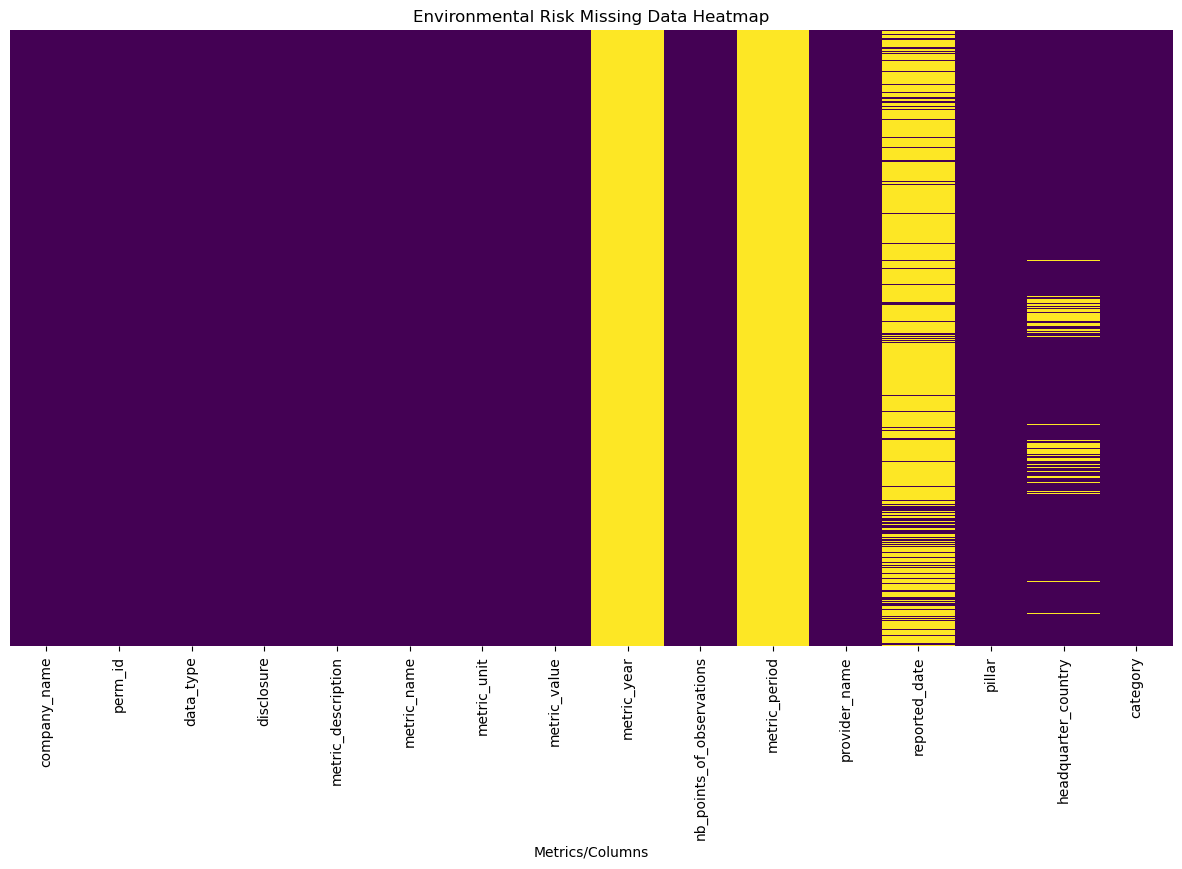

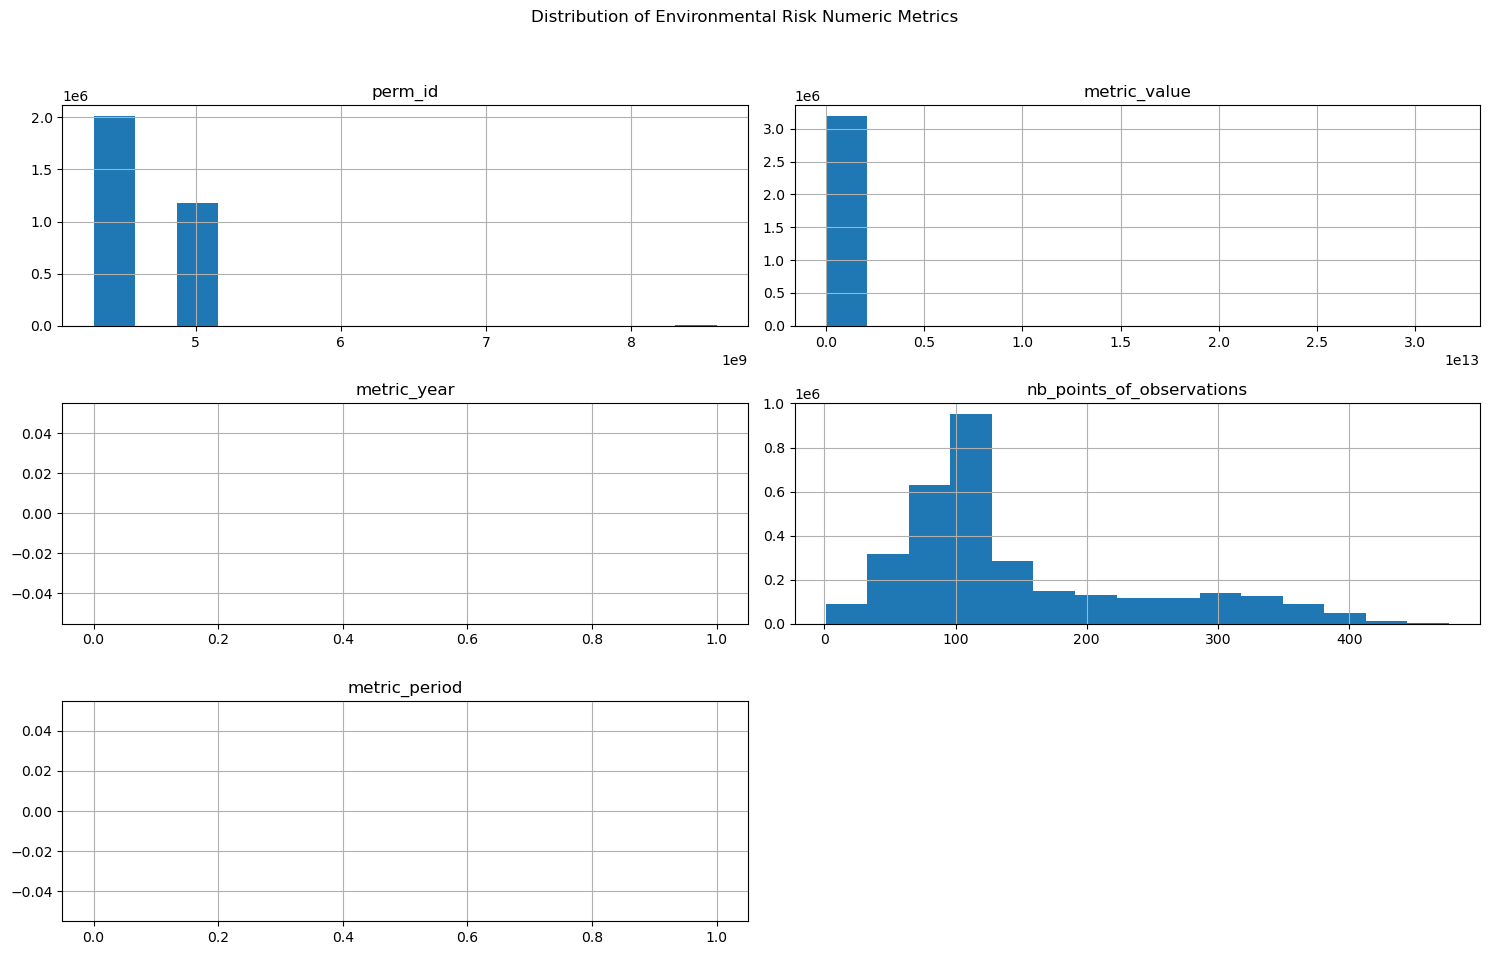

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas display options
pd.set_option('display.max_columns', None)

# Load the Environmental Risk dataset
env_risk_df = pd.read_csv("Environmental_Risk/Environmental Risk.csv")

 
# Check first few rows
print("First 5 rows of Environmental Risk data:")
print(env_risk_df.head())

# Basic dataset info
print("\nEnvironmental Risk Dataset Information:")
print(env_risk_df.info())

# Summary statistics for numeric columns
print("\nEnvironmental Risk Numeric Columns Summary:")
print(env_risk_df.describe())

# Check missing values
missing_values = env_risk_df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(env_risk_df)) * 100
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

print("\nEnvironmental Risk Missing Data Summary:")
print(missing_summary[missing_summary['Missing Values'] > 0])

# Visualization: Missing Data Heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(env_risk_df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Environmental Risk Missing Data Heatmap')
plt.xlabel('Metrics/Columns')
plt.show()

# Distribution visualization (Histograms for numerical metrics)
numeric_cols = env_risk_df.select_dtypes(include=[np.number]).columns

env_risk_df[numeric_cols].hist(bins=15, figsize=(15, 10))
plt.suptitle('Distribution of Environmental Risk Numeric Metrics')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Most Common Metrics:
 metric_name
CO2INDIRECTSCOPE2               333704
CO2DIRECTSCOPE1                 320932
WATERWITHDRAWALTOTAL            316310
NOXEMISSIONS                    298315
VOCEMISSIONS                    296868
PARTICULATE_MATTER_EMISSIONS    291325
SOXEMISSIONS                    266585
CO2INDIRECTSCOPE3               219606
WATER_USE_PAI_M10               202104
WASTETOTAL                      196852
Name: count, dtype: int64

Least Common Metrics:
 metric_name
WATER_USE_PAI_M10               202104
WASTETOTAL                      196852
AIRPOLLUTANTS_INDIRECT          176536
HAZARDOUSWASTE                  125789
AIRPOLLUTANTS_DIRECT             80779
TOXIC_CHEMICALS_REDUCTION        42633
N_OXS_OX_EMISSIONS_REDUCTION     10307
VOC_EMISSIONS_REDUCTION          10241
NATURAL_RESOURCE_USE_DIRECT       7928
CO2_NO_EQUIVALENTS                   2
Name: count, dtype: int64


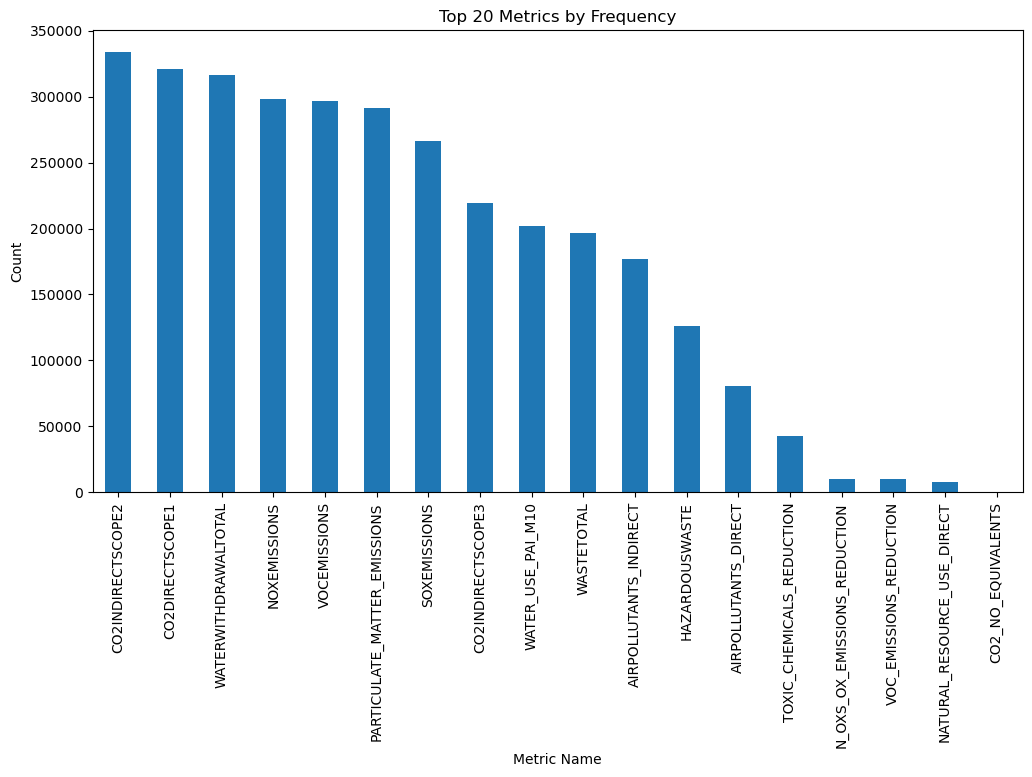

In [6]:
# Frequency analysis of metrics
metric_counts = env_risk_df['metric_name'].value_counts()

print("Most Common Metrics:\n", metric_counts.head(10))
print("\nLeast Common Metrics:\n", metric_counts.tail(10))

# Visualization
metric_counts.head(20).plot(kind='bar', figsize=(12,6), title='Top 20 Metrics by Frequency')
plt.xlabel('Metric Name')
plt.ylabel('Count')
plt.show()


First 5 rows of Environmental Risk data:
                                        company_name     perm_id data_type  \
0  Abdullah Saad Mohammed Abo Moati for Bookstore...  5052962521       int   
1  Abdullah Saad Mohammed Abo Moati for Bookstore...  5052962521       int   
2  Abdullah Saad Mohammed Abo Moati for Bookstore...  5052962521       int   
3  Abdullah Saad Mohammed Abo Moati for Bookstore...  5052962521       int   
4  Abdullah Saad Mohammed Abo Moati for Bookstore...  5052962521       int   

   disclosure                                 metric_description  \
0  CALCULATED  Does the company develop products and services...   
1    REPORTED  Does the company develop products or technolog...   
2    REPORTED  Does the company have a policy to improve its ...   
3  CALCULATED  Does the company develop products or technolog...   
4    REPORTED  Does the company reports about take-back proce...   

                      metric_name metric_unit  metric_value  metric_year  \
0   S

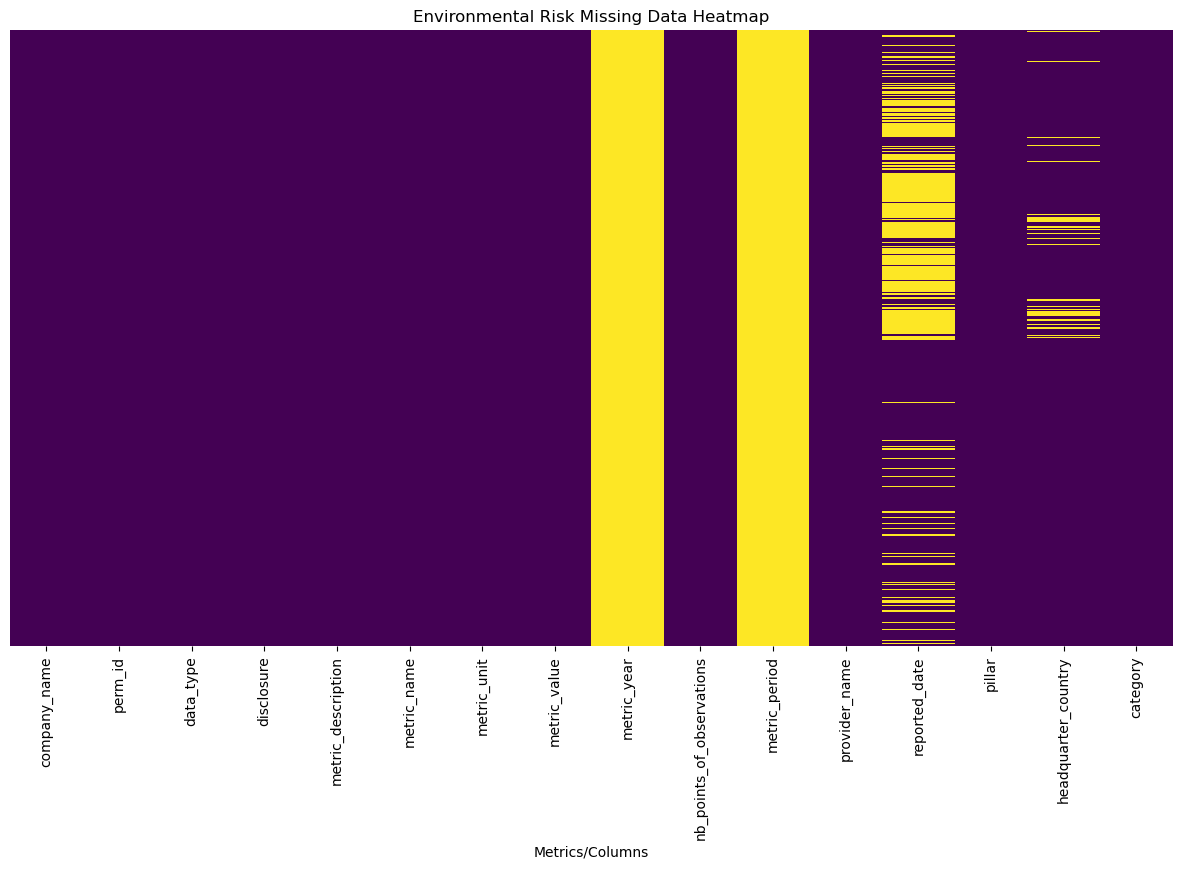

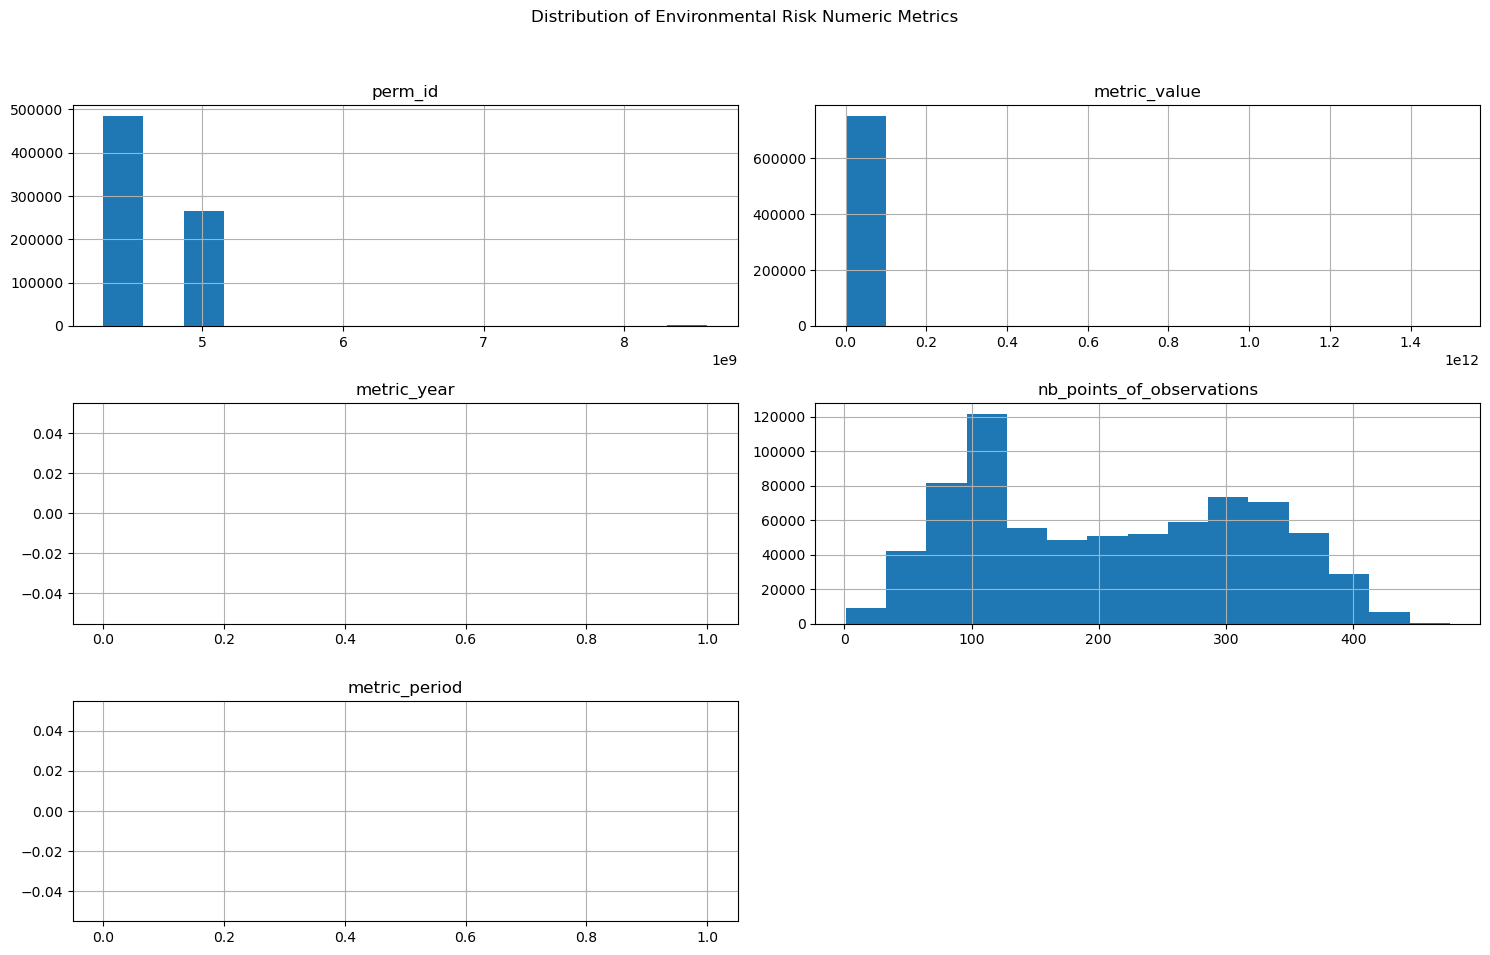

In [12]:
# Set pandas display options
pd.set_option('display.max_columns', None)

# Load the Environmental Risk dataset
env_oppr_df = pd.read_csv("Environmental_Opportunity/Environmental Opportunity.csv")

 
# Check first few rows
print("First 5 rows of Environmental Risk data:")
print(env_oppr_df.head())

# Basic dataset info
print("\nEnvironmental Risk Dataset Information:")
print(env_oppr_df.info())

# Summary statistics for numeric columns
print("\nEnvironmental Risk Numeric Columns Summary:")
print(env_oppr_df.describe())

# Check missing values
missing_values = env_oppr_df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(env_oppr_df)) * 100
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

print("\nEnvironmental Risk Missing Data Summary:")
print(missing_summary[missing_summary['Missing Values'] > 0])

# Visualization: Missing Data Heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(env_oppr_df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Environmental Risk Missing Data Heatmap')
plt.xlabel('Metrics/Columns')
plt.show()

# Distribution visualization (Histograms for numerical metrics)
numeric_cols = env_oppr_df.select_dtypes(include=[np.number]).columns

env_oppr_df[numeric_cols].hist(bins=15, figsize=(15, 10))
plt.suptitle('Distribution of Environmental Risk Numeric Metrics')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Most Common Metrics:
 metric_name
ENERGYUSETOTAL                   323812
TARGETS_WATER_EFFICIENCY          52561
POLICY_WATER_EFFICIENCY           51997
WATER_TECHNOLOGIES                51239
SUSTAINABLE_BUILDING_PRODUCTS     51036
POLICY_EMISSIONS                  49175
TARGETS_EMISSIONS                 45084
POLICY_SUSTAINABLE_PACKAGING      19495
WASTE_RECYCLED                    17386
TRANALYTICRENEWENERGYUSE          17174
Name: count, dtype: int64

Least Common Metrics:
 metric_name
POLICY_SUSTAINABLE_PACKAGING      19495
WASTE_RECYCLED                    17386
TRANALYTICRENEWENERGYUSE          17174
ENV_INVESTMENTS                   16849
RENEWENERGYCONSUMED               13234
WASTE_REDUCTION_TOTAL             12211
TAKEBACK_RECYCLING_INITIATIVES    10744
ECO_DESIGN_PRODUCTS               10515
RENEWENERGYPURCHASED               5152
RENEWENERGYPRODUCED                4841
Name: count, dtype: int64


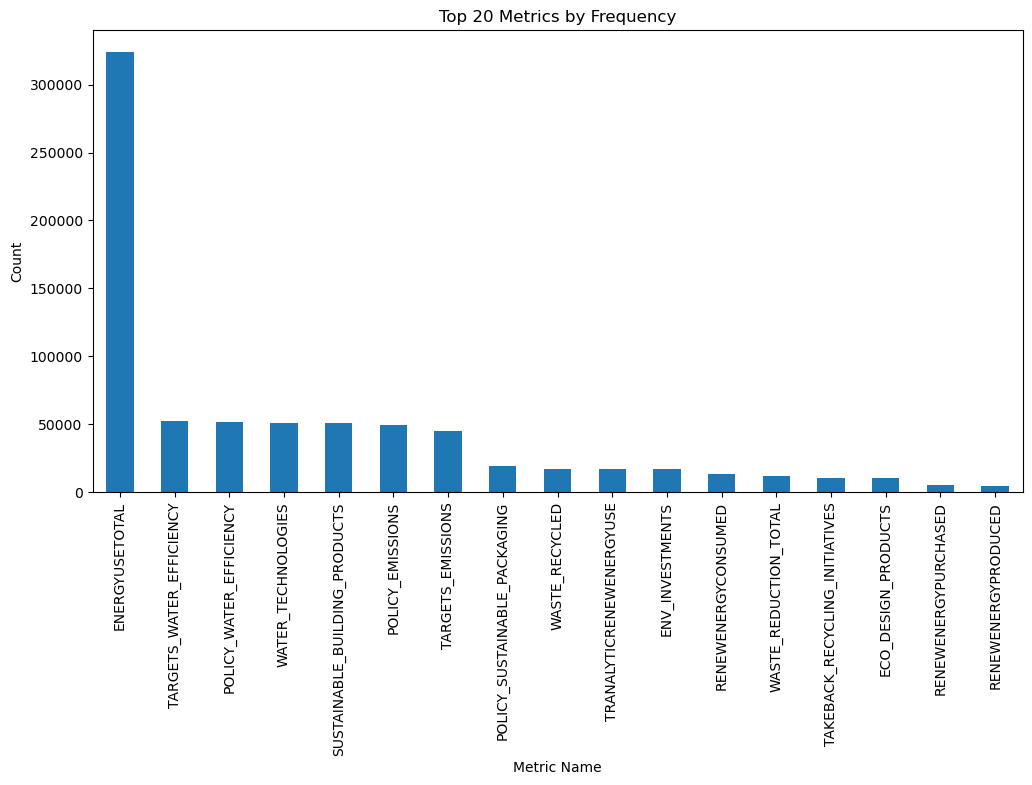

In [9]:
# Frequency analysis of metrics
metric_counts = env_oppr_df['metric_name'].value_counts()

print("Most Common Metrics:\n", metric_counts.head(10))
print("\nLeast Common Metrics:\n", metric_counts.tail(10))

# Visualization
metric_counts.head(20).plot(kind='bar', figsize=(12,6), title='Top 20 Metrics by Frequency')
plt.xlabel('Metric Name')
plt.ylabel('Count')
plt.show()


First 5 rows of Environmental Risk data:
                                        company_name     perm_id data_type  \
0  Abdullah Saad Mohammed Abo Moati for Bookstore...  5052962521     float   
1  Abdullah Saad Mohammed Abo Moati for Bookstore...  5052962521       int   
2  Abdullah Saad Mohammed Abo Moati for Bookstore...  5052962521       int   
3  Abdullah Saad Mohammed Abo Moati for Bookstore...  5052962521       int   
4  Abdullah Saad Mohammed Abo Moati for Bookstore...  5052962521       int   

   disclosure                                 metric_description  \
0    REPORTED  The average overall attendance percentage of b...   
1    REPORTED  Does the company have an audit committee with ...   
2    REPORTED  Does the company claim to apply quality manage...   
3  CALCULATED  Does the CEO simultaneously chair the board or...   
4    REPORTED  Does the company claim to apply quality manage...   

                       metric_name metric_unit  metric_value  metric_year  \
0   

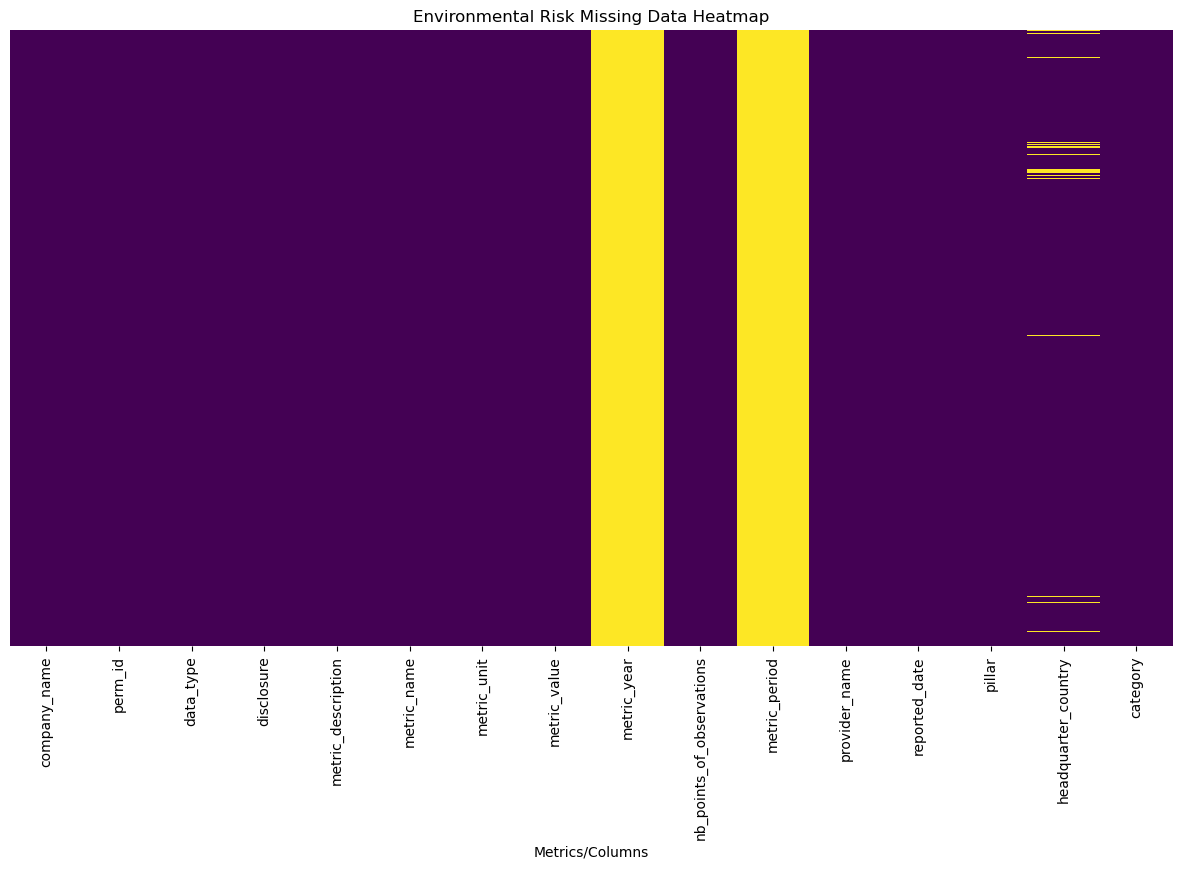

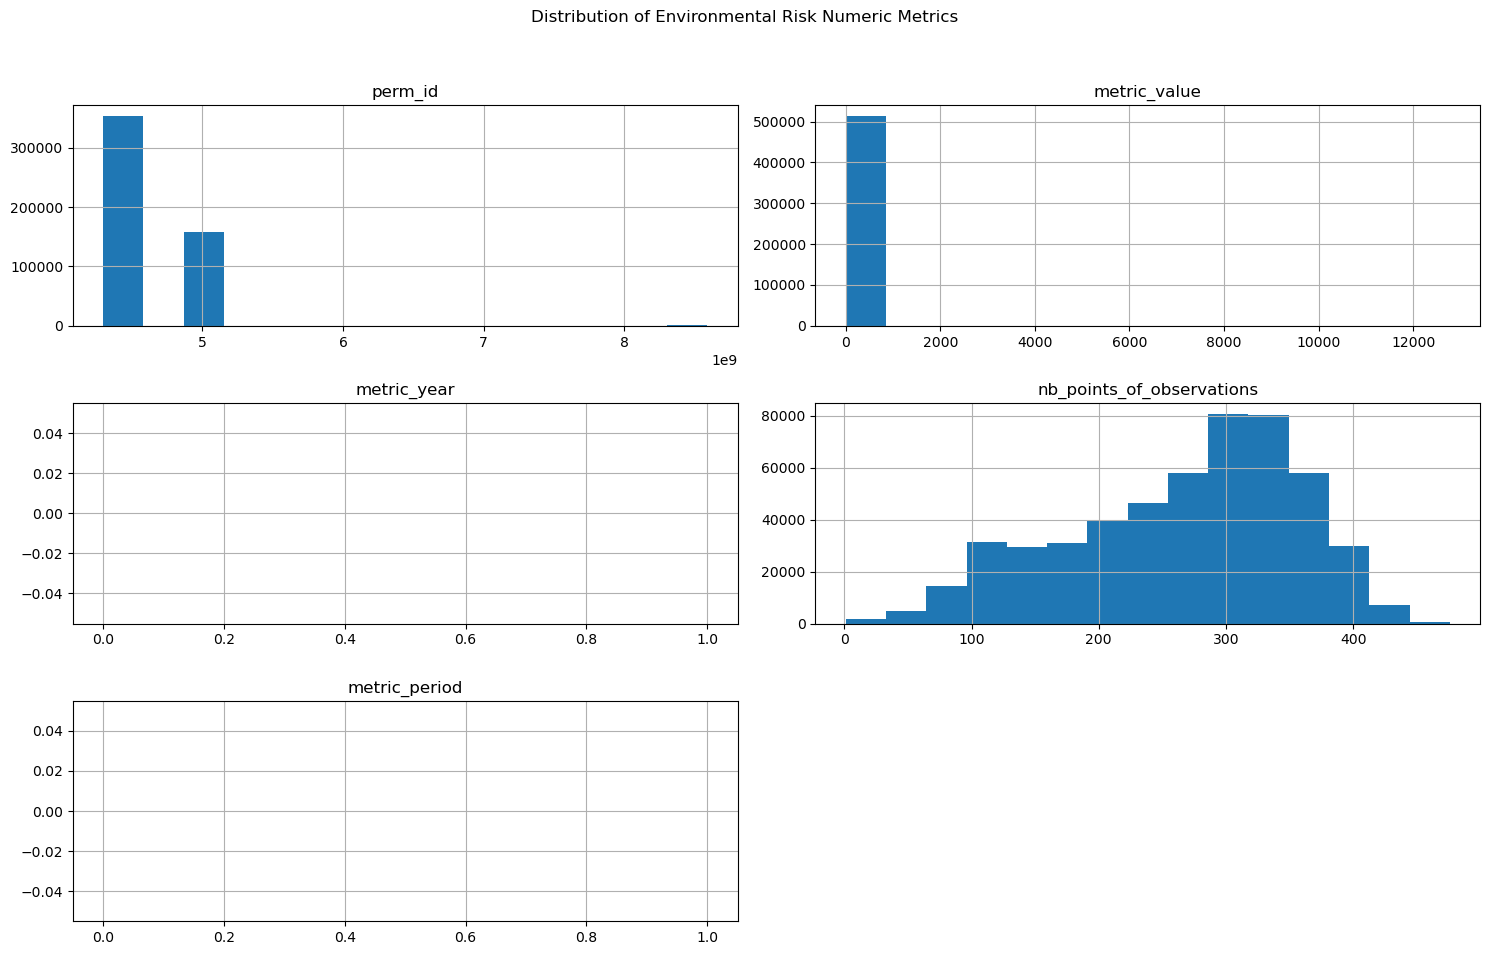

In [13]:
# Set pandas display options
pd.set_option('display.max_columns', None)

# Load the Environmental Risk dataset
gov_oppr_df = pd.read_csv("Governance_Opportunity/Governance Opportunity.csv")

 
# Check first few rows
print("First 5 rows of Environmental Risk data:")
print(gov_oppr_df.head())

# Basic dataset info
print("\nEnvironmental Risk Dataset Information:")
print(gov_oppr_df.info())

# Summary statistics for numeric columns
print("\nEnvironmental Risk Numeric Columns Summary:")
print(gov_oppr_df.describe())

# Check missing values
missing_values = gov_oppr_df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(gov_oppr_df)) * 100
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

print("\nEnvironmental Risk Missing Data Summary:")
print(missing_summary[missing_summary['Missing Values'] > 0])

# Visualization: Missing Data Heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(gov_oppr_df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Environmental Risk Missing Data Heatmap')
plt.xlabel('Metrics/Columns')
plt.show()

# Distribution visualization (Histograms for numerical metrics)
numeric_cols = gov_oppr_df.select_dtypes(include=[np.number]).columns

gov_oppr_df[numeric_cols].hist(bins=15, figsize=(15, 10))
plt.suptitle('Distribution of Environmental Risk Numeric Metrics')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Most Common Metrics:
 metric_name
ANALYTICBOARDFEMALE                69602
ANALYTICNONEXECBOARD               53881
GLOBAL_COMPACT                     51858
ANALYTICINDEPBOARD                 50912
ANALYTICAUDITCOMMIND               47080
ANALYTICCOMPCOMMIND                44804
ANALYTICNOMINATIONCOMMIND          41114
ANALYTICQMS                        36158
ANALYTIC_AUDIT_COMM_EXPERTISE      33071
ANALYTICCEO_CHAIRMAN_SEPARATION    27987
Name: count, dtype: int64

Least Common Metrics:
 metric_name
ANALYTICAUDITCOMMIND               47080
ANALYTICCOMPCOMMIND                44804
ANALYTICNOMINATIONCOMMIND          41114
ANALYTICQMS                        36158
ANALYTIC_AUDIT_COMM_EXPERTISE      33071
ANALYTICCEO_CHAIRMAN_SEPARATION    27987
ANALYTIC_VOTING_RIGHTS             21028
ANALYTICWASTERECYCLINGRATIO        14790
BOARDMEETINGATTENDANCEAVG          12972
COMMMEETINGSATTENDANCEAVG           8988
Name: count, dtype: int64


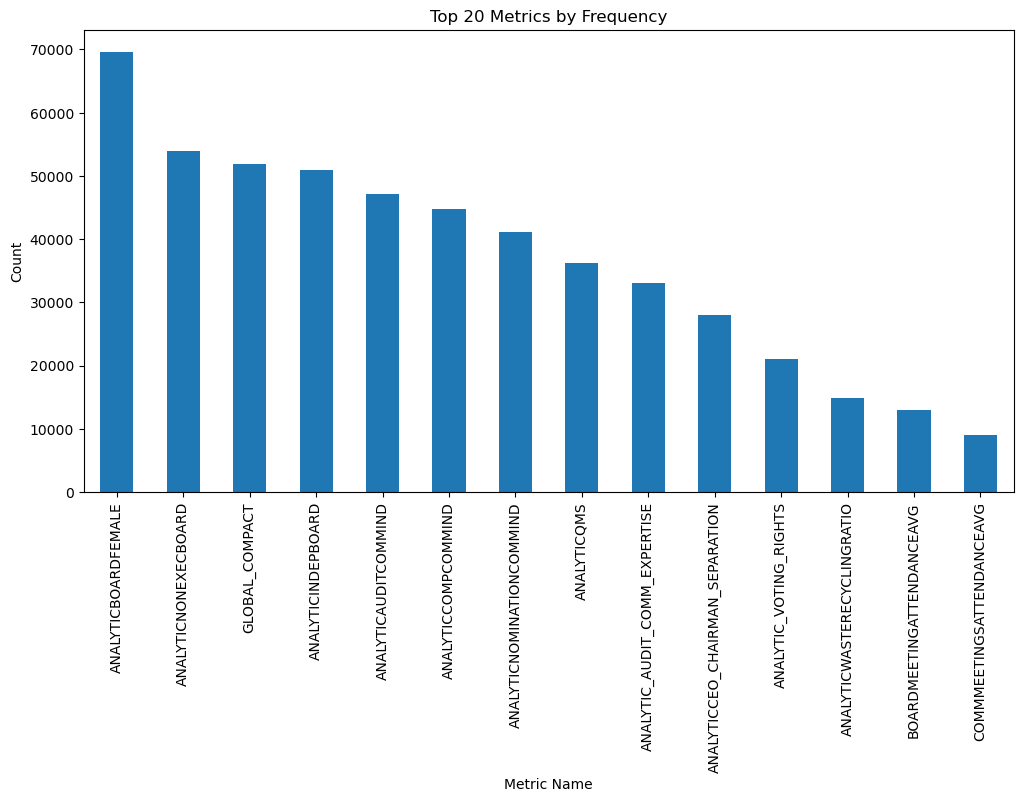

In [14]:
# Frequency analysis of metrics
metric_counts = gov_oppr_df['metric_name'].value_counts()

print("Most Common Metrics:\n", metric_counts.head(10))
print("\nLeast Common Metrics:\n", metric_counts.tail(10))

# Visualization
metric_counts.head(20).plot(kind='bar', figsize=(12,6), title='Top 20 Metrics by Frequency')
plt.xlabel('Metric Name')
plt.ylabel('Count')
plt.show()
